# AWS Elastic Kubernetes Service (EKS) Deep MNIST
In this example we will deploy a tensorflow MNIST model in Amazon Web Services' Elastic Kubernetes Service (EKS).

This tutorial will break down in the following sections:

1) Train a tensorflow model to predict mnist locally

2) Containerise the tensorflow model with our docker utility

3) Send some data to the docker model to test it

4) Install and configure AWS tools to interact with AWS

5) Use the AWS tools to create and setup EKS cluster with Seldon

6) Push and run docker image through the AWS Container Registry

7) Test our Elastic Kubernetes deployment by sending some data

Let's get started! 🚀🔥

## Dependencies:

* Helm v3.0.0+
* A Kubernetes cluster running v1.13 or above (minkube / docker-for-windows work well if enough RAM)
* kubectl v1.14+
* EKS CLI v0.1.32
* AWS Cli v1.16.163
* Python 3.6+
* Python DEV requirements


## 1) Train a tensorflow model to predict mnist locally
We will load the mnist images, together with their labels, and then train a tensorflow model to predict the right labels

In [45]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)
import tensorflow as tf

if __name__ == '__main__':
    
    x = tf.placeholder(tf.float32, [None,784], name="x")

    W = tf.Variable(tf.zeros([784,10]))
    b = tf.Variable(tf.zeros([10]))

    y = tf.nn.softmax(tf.matmul(x,W) + b, name="y")

    y_ = tf.placeholder(tf.float32, [None, 10])

    cross_entropy = tf.reduce_mean(-tf.reduce_sum(y_ * tf.log(y), reduction_indices=[1]))

    train_step = tf.train.GradientDescentOptimizer(0.5).minimize(cross_entropy)

    init = tf.initialize_all_variables()

    sess = tf.Session()
    sess.run(init)

    for i in range(1000):
        batch_xs, batch_ys = mnist.train.next_batch(100)
        sess.run(train_step, feed_dict={x: batch_xs, y_: batch_ys})

    correct_prediction = tf.equal(tf.argmax(y,1), tf.argmax(y_,1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    print(sess.run(accuracy, feed_dict = {x: mnist.test.images, y_:mnist.test.labels}))

    saver = tf.train.Saver()

    saver.save(sess, "model/deep_mnist_model")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
0.9194


## 2) Containerise the tensorflow model with our docker utility

First you need to make sure that you have added the .s2i/environment configuration file in this folder with the following content:

In [118]:
!cat .s2i/environment

MODEL_NAME=DeepMnist
API_TYPE=REST
SERVICE_TYPE=MODEL
PERSISTENCE=0


Now we can build a docker image named "deep-mnist" with the tag 0.1

In [2]:
!s2i build . seldonio/seldon-core-s2i-python36:1.6.0-dev deep-mnist:0.1

---> Installing application source...
---> Installing dependencies ...
Looking in links: /whl
Url '/whl' is ignored. It is either a non-existing path or lacks a specific scheme.
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Build completed successfully


## 3) Send some data to the docker model to test it
We first run the docker image we just created as a container called "mnist_predictor"

In [119]:
!docker run --name "mnist_predictor" -d --rm -p 5000:5000 deep-mnist:0.1

5157ab4f516bd0dea11b159780f31121e9fb41df6394e0d6d631e6e0d572463b


Send some random features that conform to the contract

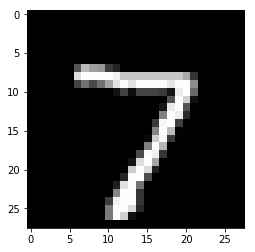

Expected label:  7.0 . One hot encoding:  [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


In [120]:
import matplotlib.pyplot as plt
# This is the variable that was initialised at the beginning of the file
i = [0]
x = mnist.test.images[i]
y = mnist.test.labels[i]
plt.imshow(x.reshape((28, 28)), cmap='gray')
plt.show()
print("Expected label: ", np.sum(range(0,10) * y), ". One hot encoding: ", y)

In [144]:
from seldon_core.seldon_client import SeldonClient
import math
import numpy as np

# We now test the REST endpoint expecting the same result
endpoint = "0.0.0.0:5000"
batch = x
payload_type = "ndarray"

sc = SeldonClient(microservice_endpoint=endpoint)

# We use the microservice, instead of the "predict" function
client_prediction = sc.microservice(
    data=batch,
    method="predict",
    payload_type=payload_type,
    names=["tfidf"])

for proba, label in zip(client_prediction.response.data.ndarray.values[0].list_value.ListFields()[0][1], range(0,10)):
    print(f"LABEL {label}:\t {proba.number_value*100:6.4f} %")

LABEL 0:	 0.0068 %
LABEL 1:	 0.0000 %
LABEL 2:	 0.0085 %
LABEL 3:	 0.3409 %
LABEL 4:	 0.0002 %
LABEL 5:	 0.0020 %
LABEL 6:	 0.0000 %
LABEL 7:	 99.5371 %
LABEL 8:	 0.0026 %
LABEL 9:	 0.1019 %


In [145]:
!docker rm mnist_predictor --force

mnist_predictor


## 4) Install and configure AWS tools to interact with AWS

First we install the awscli

In [8]:
!pip install awscli --upgrade --user

  Using cached https://files.pythonhosted.org/packages/f6/45/259a98719e7c7defc9be4cc00fbfb7ccf699fbd1f74455d8347d0ab0a1df/awscli-1.16.163-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/db/c8/7dcf9dbcb22429512708fe3a547f8b6101c0d02137acbd892505aee57adf/colorama-0.3.9-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/ec/3b/029218966ce62ae9824a18730de862ac8fc5a0e8083d07d1379815e7cca1/botocore-1.12.153-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/e1/ae/baedc9cb175552e95f3395c43055a6a5e125ae4d48a1d7a924baca83e92e/rsa-3.4.2-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/7b/7c/c9386b82a25115cccf1903441bba3cbadcfae7b678a20167347fa8ded34c/pyasn1-0.4.5-py2.py3-none-any.whl


### Configure aws so it can talk to your server 
(if you are getting issues, make sure you have the permmissions to create clusters)

In [20]:
%%bash 
# You must make sure that the access key and secret are changed
aws configure << END_OF_INPUTS
YOUR_ACCESS_KEY
YOUR_ACCESS_SECRET
us-west-2
json
END_OF_INPUTS

AWS Access Key ID [****************SF4A]: AWS Secret Access Key [****************WLHu]: Default region name [eu-west-1]: Default output format [json]: 

### Install EKCTL
*IMPORTANT*: These instructions are for linux
Please follow the official installation of ekctl at: https://docs.aws.amazon.com/eks/latest/userguide/getting-started-eksctl.html

In [23]:
!curl --silent --location "https://github.com/weaveworks/eksctl/releases/download/latest_release/eksctl_$(uname -s)_amd64.tar.gz" | tar xz 

In [25]:
!chmod 755 ./eksctl

In [27]:
!./eksctl version

[ℹ]  version.Info{BuiltAt:"", GitCommit:"", GitTag:"0.1.32"}


## 5) Use the AWS tools to create and setup EKS cluster with Seldon
In this example we will create a cluster with 2 nodes, with a minimum of 1 and a max of 3. You can tweak this accordingly.

If you want to check the status of the deployment you can go to AWS CloudFormation or to the EKS dashboard.

It will take 10-15 minutes (so feel free to go grab a ☕). 

*IMPORTANT*: If you get errors in this step it is most probably IAM role access requirements, which requires you to discuss with your administrator.

In [107]:
%%bash
./eksctl create cluster \
--name demo-eks-cluster \
--region us-west-2 \
--nodes 2 

Process is interrupted.


### Configure local kubectl 
We want to now configure our local Kubectl so we can actually reach the cluster we've just created

In [108]:
!aws eks --region us-west-2 update-kubeconfig --name demo-eks-cluster

Updated context arn:aws:eks:eu-west-1:271049282727:cluster/deepmnist in /home/alejandro/.kube/config


And we can check if the context has been added to kubectl config (contexts are basically the different k8s cluster connections)
You should be able to see the context as "...aws:eks:eu-west-1:27...". 
If it's not activated you can activate that context with kubectlt config set-context <CONTEXT_NAME>

In [109]:
!kubectl config get-contexts

CURRENT   NAME                                                   CLUSTER                                                AUTHINFO                                               NAMESPACE
*         arn:aws:eks:eu-west-1:271049282727:cluster/deepmnist   arn:aws:eks:eu-west-1:271049282727:cluster/deepmnist   arn:aws:eks:eu-west-1:271049282727:cluster/deepmnist   
          docker-desktop                                         docker-desktop                                         docker-desktop                                         
          docker-for-desktop                                     docker-desktop                                         docker-desktop                                         
          gke_ml-engineer_us-central1-a_security-cluster-1       gke_ml-engineer_us-central1-a_security-cluster-1       gke_ml-engineer_us-central1-a_security-cluster-1       


## Setup Seldon Core

Use the setup notebook to [Setup Cluster](https://docs.seldon.io/projects/seldon-core/en/latest/examples/seldon_core_setup.html#Setup-Cluster) with [Ambassador Ingress](https://docs.seldon.io/projects/seldon-core/en/latest/examples/seldon_core_setup.html#Ambassador) and [Install Seldon Core](https://docs.seldon.io/projects/seldon-core/en/latest/examples/seldon_core_setup.html#Install-Seldon-Core). Instructions [also online](https://docs.seldon.io/projects/seldon-core/en/latest/examples/seldon_core_setup.html).

## Push docker image
In order for the EKS seldon deployment to access the image we just built, we need to push it to the Elastic Container Registry (ECR).

If you have any issues please follow the official AWS documentation: https://docs.aws.amazon.com/AmazonECR/latest/userguide/what-is-ecr.html

### First we create a registry
You can run the following command, and then see the result at https://us-west-2.console.aws.amazon.com/ecr/repositories?#

In [110]:
!aws ecr create-repository --repository-name seldon-repository --region us-west-2

{
    "repository": {
        "repositoryArn": "arn:aws:ecr:us-west-2:271049282727:repository/seldon-repository",
        "registryId": "271049282727",
        "repositoryName": "seldon-repository",
        "repositoryUri": "271049282727.dkr.ecr.us-west-2.amazonaws.com/seldon-repository",
        "createdAt": 1558535798.0
    }
}


### Now prepare docker image
We need to first tag the docker image before we can push it

In [111]:
%%bash
export AWS_ACCOUNT_ID=""
export AWS_REGION="us-west-2"
if [ -z "$AWS_ACCOUNT_ID" ]; then
    echo "ERROR: Please provide a value for the AWS variables"
    exit 1
fi

docker tag deep-mnist:0.1 "$AWS_ACCOUNT_ID.dkr.ecr.$AWS_REGION.amazonaws.com/seldon-repository"

### We now login to aws through docker so we can access the repository

In [112]:
!`aws ecr get-login --no-include-email --region us-west-2`

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/alejandro/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded


### And push the image
Make sure you add your AWS Account ID

In [113]:
%%bash
export AWS_ACCOUNT_ID=""
export AWS_REGION="us-west-2"
if [ -z "$AWS_ACCOUNT_ID" ]; then
    echo "ERROR: Please provide a value for the AWS variables"
    exit 1
fi

docker push "$AWS_ACCOUNT_ID.dkr.ecr.$AWS_REGION.amazonaws.com/seldon-repository"

The push refers to repository [271049282727.dkr.ecr.us-west-2.amazonaws.com/seldon-repository]
f7d0d000c138: Preparing
987f3f1afb00: Preparing
00d16a381c47: Preparing
bb01f50d544a: Preparing
fcb82c6941b5: Preparing
67290e35c458: Preparing
b813745f5bb3: Preparing
ffecb18e9f0b: Preparing
f50f856f49fa: Preparing
80b43ad4adf9: Preparing
14c77983a1cf: Preparing
a22a5ac18042: Preparing
6257fa9f9597: Preparing
578414b395b9: Preparing
abc3250a6c7f: Preparing
13d5529fd232: Preparing
67290e35c458: Waiting
b813745f5bb3: Waiting
ffecb18e9f0b: Waiting
f50f856f49fa: Waiting
80b43ad4adf9: Waiting
6257fa9f9597: Waiting
14c77983a1cf: Waiting
a22a5ac18042: Waiting
578414b395b9: Waiting
abc3250a6c7f: Waiting
13d5529fd232: Waiting
987f3f1afb00: Pushed
fcb82c6941b5: Pushed
bb01f50d544a: Pushed
f7d0d000c138: Pushed
ffecb18e9f0b: Pushed
b813745f5bb3: Pushed
f50f856f49fa: Pushed
67290e35c458: Pushed
14c77983a1cf: Pushed
578414b395b9: Pushed
80b43ad4adf9: Pushed
13d5529fd232: Pushed
6257fa9f9597: Pushed
abc325

## Running the Model
We will now run the model.

Let's first have a look at the file we'll be using to trigger the model:

In [127]:
!cat deep_mnist.json

{
    "apiVersion": "machinelearning.seldon.io/v1alpha2",
    "kind": "SeldonDeployment",
    "metadata": {
        "labels": {
            "app": "seldon"
        },
        "name": "deep-mnist"
    },
    "spec": {
        "annotations": {
            "project_name": "Tensorflow MNIST",
            "deployment_version": "v1"
        },
        "name": "deep-mnist",
        "predictors": [
            {
                "componentSpecs": [{
                    "spec": {
                        "containers": [
                            {
                                "image": "271049282727.dkr.ecr.us-west-2.amazonaws.com/seldon-repository:latest",
                                "imagePullPolicy": "IfNotPresent",
                                "name": "classifier",
                                "resources": {
                                    "requests": {
                                        "memory": "1Mi"
                                    }
                             

Now let's trigger seldon to run the model.

We basically have a yaml file, where we want to replace the value "REPLACE_FOR_IMAGE_AND_TAG" for the image you pushed

In [165]:
%%bash
export AWS_ACCOUNT_ID=""
export AWS_REGION="us-west-2"
if [ -z "$AWS_ACCOUNT_ID" ]; then
    echo "ERROR: Please provide a value for the AWS variables"
    exit 1
fi

sed 's|REPLACE_FOR_IMAGE_AND_TAG|'"$AWS_ACCOUNT_ID"'.dkr.ecr.'"$AWS_REGION"'.amazonaws.com/seldon-repository|g' deep_mnist.json | kubectl apply -f -

error: unable to recognize "STDIN": Get https://461835FD3FF52848655C8F09FBF5EEAA.yl4.us-west-2.eks.amazonaws.com/api?timeout=32s: dial tcp: lookup 461835FD3FF52848655C8F09FBF5EEAA.yl4.us-west-2.eks.amazonaws.com on 1.1.1.1:53: no such host


CalledProcessError: Command 'b'export AWS_ACCOUNT_ID="2710"\nexport AWS_REGION="us-west-2"\nif [ -z "$AWS_ACCOUNT_ID" ]; then\n    echo "ERROR: Please provide a value for the AWS variables"\n    exit 1\nfi\n\nsed \'s|REPLACE_FOR_IMAGE_AND_TAG|\'"$AWS_ACCOUNT_ID"\'.dkr.ecr.\'"$AWS_REGION"\'.amazonaws.com/seldon-repository|g\' deep_mnist.json | kubectl apply -f -\n'' returned non-zero exit status 1.

And let's check that it's been created.

You should see an image called "deep-mnist-single-model...".

We'll wait until STATUS changes from "ContainerCreating" to "Running"

In [20]:
!kubectl get pods

NAME                                              READY   STATUS    RESTARTS   AGE
ambassador-5475779f98-7bhcw                       1/1     Running   0          21m
ambassador-5475779f98-986g5                       1/1     Running   0          21m
ambassador-5475779f98-zcd28                       1/1     Running   0          21m
deep-mnist-single-model-42ed9d9-fdb557d6b-6xv2h   2/2     Running   0          18m


## Test the model
Now we can test the model, let's first find out what is the URL that we'll have to use:

In [22]:
!kubectl get svc ambassador -o jsonpath='{.status.loadBalancer.ingress[0].hostname}' 

a68bbac487ca611e988060247f81f4c1-707754258.us-west-2.elb.amazonaws.com

We'll use a random example from our dataset

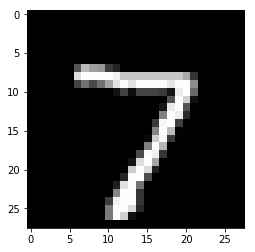

Expected label:  7.0 . One hot encoding:  [[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]]


In [42]:
import matplotlib.pyplot as plt
# This is the variable that was initialised at the beginning of the file
i = [0]
x = mnist.test.images[i]
y = mnist.test.labels[i]
plt.imshow(x.reshape((28, 28)), cmap='gray')
plt.show()
print("Expected label: ", np.sum(range(0,10) * y), ". One hot encoding: ", y)

We can now add the URL above to send our request:

In [112]:
from seldon_core.seldon_client import SeldonClient
import math
import numpy as np

host = "a68bbac487ca611e988060247f81f4c1-707754258.us-west-2.elb.amazonaws.com"
port = "80" # Make sure you use the port above
batch = x
payload_type = "ndarray"

sc = SeldonClient(
    gateway="ambassador", 
    ambassador_endpoint=host + ":" + port,
    namespace="default")

client_prediction = sc.predict(
    data=batch, 
    deployment_name="deep-mnist",
    names=["text"],
    payload_type=payload_type)

print(client_prediction)

Success:True message:
Request:
data {
  names: "text"
  ndarray {
    values {
      list_value {
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
          number_value: 0.0
        }
        values {
     

### Let's visualise the probability for each label
It seems that it correctly predicted the number 7

In [117]:
for proba, label in zip(client_prediction.response.data.ndarray.values[0].list_value.ListFields()[0][1], range(0,10)):
    print(f"LABEL {label}:\t {proba.number_value*100:6.4f} %")

LABEL 0:	 0.0068 %
LABEL 1:	 0.0000 %
LABEL 2:	 0.0085 %
LABEL 3:	 0.3409 %
LABEL 4:	 0.0002 %
LABEL 5:	 0.0020 %
LABEL 6:	 0.0000 %
LABEL 7:	 99.5371 %
LABEL 8:	 0.0026 %
LABEL 9:	 0.1019 %
